# Simulating a blue-detuned MOT for CaOH

In [2]:
# Import the primary packages required for the notebook
using
    Revise,
    QuantumStates,            # for calculating molecular structure
    OpticalBlochEquations,    # for solving optical Bloch equations
    UnitsToValue              # for numerical values
;

[ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]
  ** incremental compilation may be fatally broken for this module **



### Create Hamiltonian for the $X^2\Sigma^+(000, N=1)$ state, with Zeeman terms

We first create a Hamiltonian for the $N=1$ state of the ground electronic $X^2\Sigma^+(000)$ state. Creating a Hamiltonian requiries defining three distinct objects:
1) A basis, accomplished using the function `enumerate_states`, which takes a basis state type as its first argument and appropriate bounds for the quantum numbers. Note that we let the basis include states of $N \in [0,3]$, not just $N=1$, since we could have matrix elements connecting the $N=1$ states to other rotational states. Such matrix elements are only included in the Hamiltonian provided that the basis includes all associated basis states. 
2) An operator for the Hamiltonian based on matrix elements that have been defined for the given basis state type. The syntax is to write the operator as a sum of terms of the form [parameter symbol] * [matrix operator], e.g., `BX * Rotation`.
3) A set of parameters using the macro `QuantumStates.@params` (note that other packages export a `@params` macro, hence the inclusion of the package name; normally we could just write `@params`). These parameters must correspond one-to-one with the parameter symbols used in the definition of the operator.

Additional terms can later be added to the Hamiltonian object using the `add_to_H` function, see below for an example.

Finally, the Hamiltonian is evaluated using `evaluate!` and then solved using `QuantumStates.solve!` (other packages export a `solve!` function, similarly to `@params` and the package name is therefore included in the function call).

In [147]:
QN_bounds = (
    S = 1/2, 
    I = 1/2, 
    Λ = 0, 
    N = 0:3
)
X_state_basis = enumerate_states(HundsCaseB_LinearMolecule, QN_bounds)

X_state_operator = :(
    BX * Rotation + 
    DX * RotationDistortion + 
    γX * SpinRotation + 
    bFX * Hyperfine_IS + 
    cX * (Hyperfine_Dipolar/3)
)

X_state_parameters = QuantumStates.@params begin
    BX = 0.33441 * c * 1e2
    DX = 0.3869e-6 * c * 1e2
    γX = 0.001134 * c * 1e2
    bFX = 2.602e6
    cX = 2.053e6
end

X_state_ham = Hamiltonian(basis=X_state_basis, operator=X_state_operator, parameters=X_state_parameters)

# Add Zeeman terms
Zeeman_z(state, state′) = Zeeman(state, state′, 0)
X_state_ham = add_to_H(X_state_ham, :B_z, (gS * μB / h) * Zeeman_z)
X_state_ham.parameters.B_z = 0.

evaluate!(X_state_ham)
QuantumStates.solve!(X_state_ham)
;

### Create Hamiltonian for the $A^2\Pi_{1/2}(000, J=1/2+)$ state

We similarly define a Hamiltonian for the excited electronic state.

In [148]:
QN_bounds = (
    S = 1/2,
    I = 1/2,
    Λ = (-1,1),
    J = 1/2:5/2
)
A_state_basis = enumerate_states(HundsCaseA_LinearMolecule, QN_bounds)

A_state_operator = :(
    T_A * DiagonalOperator +
    Be_A * Rotation + 
    Aso_A * SpinOrbit +
    q_A * ΛDoubling_q +
    p_A * ΛDoubling_p2q + q_A * (2ΛDoubling_p2q)
)

# Spectroscopic constants for CaOH, A state
A_state_parameters = QuantumStates.@params begin
    T_A = 15998.122 * c * 1e2
    Be_A = 0.3412200 * c * 1e2
    Aso_A = 66.8181 * c * 1e2
    p_A = -0.04287 * c * 1e2
    q_A = -0.3257e-3 * c * 1e2
end

A_state_ham = Hamiltonian(basis=A_state_basis, operator=A_state_operator, parameters=A_state_parameters)
evaluate!(A_state_ham)
QuantumStates.solve!(A_state_ham)
;

### Convert relevant $A$ states ($J=1/2-$) to a Hund's case (b) basis

We used a Hund's case (a) basis to define the Hamiltonian for the excited $A$ state. In order to compute transition dipole moments with the ground state we wish to convert these states to a Hund's case (b). We can accomplish this by simply defining a new basis that has all the Hund's case (b) states required for this conversion, and then using the function `convert_basis`. 

In [149]:
A_state_J12_pos_parity_states = A_state_ham.states[5:8]

QN_bounds = (
    S = 1/2, 
    I = 1/2, 
    Λ = (-1,1), 
    N = 0:3
)
A_state_caseB_basis = enumerate_states(HundsCaseB_LinearMolecule, QN_bounds)

ground_states = X_state_ham.states[5:16]
excited_states = convert_basis(A_state_J12_pos_parity_states, A_state_caseB_basis)

states = [ground_states; excited_states]
;

### Compute dipole moments between states

The optical Bloch equations (OBE) solver requires a matrix `d` for the transition dipole moments (TDMs) among all states relevant to the simulation. In our case we have 12 ground states and 4 excited states, so $d$ will have dimensions $16 \times 16 \times 3$. TDMs between two sets of states can be computed by first getting the TDMs between the two bases used to define the two sets of states (using `get_tdms_two_basis`), and then using those TDMs between basis states to compute the TDMs between the sets of states (using `tdms_between_states!`).

In [150]:
d = zeros(ComplexF64, 16, 16, 3)
d_ge = zeros(ComplexF64, 12, 4, 3)

basis_tdms = get_tdms_two_bases(X_state_ham.basis, A_state_caseB_basis, TDM)
tdms_between_states!(d_ge, basis_tdms, ground_states, excited_states)
d[1:12, 13:16, :] .= d_ge
;

### Zeeman plot for the $X^2\Sigma^+(N=1)$ state in CaOH

Before carrying on with solving the OBEs, let's do a quick sanity check of our Hamiltonian by creating a plot of Zeeman shifts for the ground $X$ states involved in the simulation. `QuantumStates` includes functionality to create such plots relatively easily, as shown below. Note that `scan_values` is a dictionary mapping the scanned parameter (`Bs`) to the eigenenergies for that parameter value.

In [151]:
function H_func!(H, scan_values)
    H.parameters.B_z = scan_values[1]
    evaluate!(H)
    QuantumStates.solve!(H)
    return nothing
end
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.632915 seconds (608.82 k allocations: 365.733 MiB, 3.70% gc time, 120.97% compilation time)


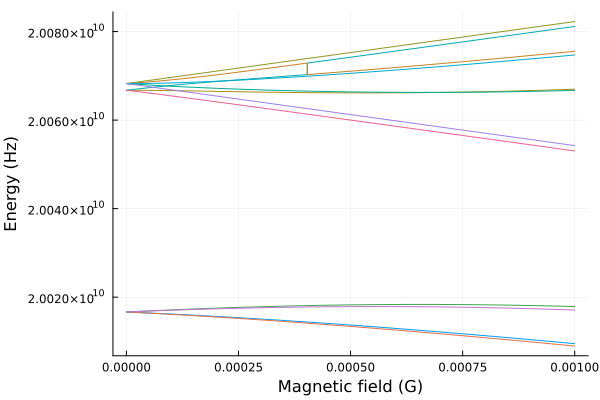

In [152]:
Bs = (0:0.01:10) .* 1e-4 # scan from 0 to 10 G
scan_params = (
    B_z = Bs,
    );
iterator = Iterators.product
@time scan_values, tracked_idxs = scan_parameters(deepcopy(X_state_ham), scan_params, iterator, H_func!, H -> energy.(H.states), n_threads=10)

using Plots
scan_matrix = hcat(values(scan_values)...)'

plot(Bs, scan_matrix[:,5:16], legend=nothing)
plot!(
    xlabel=("Magnetic field (G)"),
    ylabel=("Energy (Hz)")
)

### Set up optical Bloch equations solver and define parameters

In [153]:
# A few constants used for the simulation
λ = 626e-9
Γ = 2π * 6.4e6
m = @with_unit 57 "u"
k = 2π / λ
;

We need to define the lasers that we wish to consider for our simulation. This is accomplished using the type `Field`, which takes a (unit!) $k$ vector, a function to set the polarization (defined in the spherical basis), a laser frequency (in angular units), and a saturation parameter. For this simulation we define 12 lasers, 6 for each of the two separate spin-rotation components in our ground state.

In [154]:
J12_energy = energy(states[1])
J32_energy = energy(states[5])
A_energy = energy(states[13])

s_func(s) = (r,t) -> s
s_J12 = s_func(10.0)
s_J32 = s_func(10.0)
δJ12 = +2Γ
δJ32 = +3.5Γ
pol_J12 = σ⁺
pol_J32 = σ⁺

ω_J12 = 2π * (A_energy - J12_energy) + δJ12
ω_J32 = 2π * (A_energy - J32_energy) + δJ32

# This function sets the polarization as a function of time; here it's just set to be constant
ϵ(ϵ_val) = t -> ϵ_val

k̂ = +x̂; ϵ1 = ϵ(rotate_pol(pol_J12, k̂)); laser1 = Field(k̂, ϵ1, ω_J12, s_J12)
k̂ = -x̂; ϵ2 = ϵ(rotate_pol(pol_J12, k̂)); laser2 = Field(k̂, ϵ2, ω_J12, s_J12)
k̂ = +ŷ; ϵ3 = ϵ(rotate_pol(pol_J12, k̂)); laser3 = Field(k̂, ϵ3, ω_J12, s_J12)
k̂ = -ŷ; ϵ4 = ϵ(rotate_pol(pol_J12, k̂)); laser4 = Field(k̂, ϵ4, ω_J12, s_J12)
k̂ = +ẑ; ϵ5 = ϵ(rotate_pol(pol_J12, k̂)); laser5 = Field(k̂, ϵ5, ω_J12, s_J12)
k̂ = -ẑ; ϵ6 = ϵ(rotate_pol(pol_J12, k̂)); laser6 = Field(k̂, ϵ6, ω_J12, s_J12)
lasers_J12 = [laser1, laser2, laser3, laser4, laser5, laser6]

k̂ = +x̂; ϵ7  = ϵ(rotate_pol(pol_J32, k̂)); laser7  = Field(k̂, ϵ7,  ω_J32, s_J32)
k̂ = -x̂; ϵ8  = ϵ(rotate_pol(pol_J32, k̂)); laser8  = Field(k̂, ϵ8,  ω_J32, s_J32)
k̂ = +ŷ; ϵ9  = ϵ(rotate_pol(pol_J32, k̂)); laser9  = Field(k̂, ϵ9,  ω_J32, s_J32)
k̂ = -ŷ; ϵ10 = ϵ(rotate_pol(pol_J32, k̂)); laser10 = Field(k̂, ϵ10, ω_J32, s_J32)
k̂ = +ẑ; ϵ11 = ϵ(rotate_pol(pol_J32, k̂)); laser11 = Field(k̂, ϵ11, ω_J32, s_J32)
k̂ = -ẑ; ϵ12 = ϵ(rotate_pol(pol_J32, k̂)); laser12 = Field(k̂, ϵ12, ω_J32, s_J32)
lasers_J32 = [laser7, laser8, laser9, laser10, laser11, laser12]

lasers = [lasers_J12; lasers_J32]
;

The OBE solver requires a set of parameters `p`, which are defined using the function `obe`. Most of these arguments should be self-explanatory, but a few require special attention:
* `freq_res` _(type: Float64)_: The resolution used when rounding frequencies (and the velocity) in order to ensure that the OBEs reach a quasi-periodic steady state. Defined in units of Γ and typically set to 1e-1 (or 1e-2 for low velocities).
* `extra_p` _(type: NamedTuple)_: Allows the user to define a set of "extra" parameters that may be used during the simulation. This is mostly relevant in cases where we wish to solve the OBEs several times and we have some parameter that is changing between solves, e.g., we may need to update our TDMs if we want to solve the OBEs for a range of magnetic fields. In that case it's helpful to ensure that the solver has access to the underlying Hamiltonian, as well as any data structures we've defined to help in updating the TDMs.

In [155]:
# Set initial conditions
particle = OpticalBlochEquations.Particle()

ρ0 = zeros(ComplexF64, length(states), length(states))
ρ0[1,1] = 1.0

freq_res = 1e-1
p = obe(ρ0, particle, states, lasers, d, true, true; λ=λ, Γ=Γ, freq_res=freq_res)
;

After defining `p`, we're free to update any of its parameters before solving the OBEs. For example, we can update the initial position `r0` to $\mathbf{r}_0 = (0,0,0.5)~k^{-1}$ and the velocity `v` to $\mathbf{v} = (0,0,1)~\text{m/s}$ as shown below. Note that position and velocity need to have units of 1/k and Γ/k in the simulation, so since we defined the velocity in SI units it must be divided by Γ/k. We also need to round the velocity again (using `round_vel`) after updating it (this rounding is automatically performed inside `obe` when `p` is first defined but must be performed again if `v` is changed).

In [156]:
p.r0 = (0., 0., 0.5)
p.v = (0., 0., 1.0) ./ (Γ / k)
p.v = round_vel(p.v, p.freq_res)
;

Finally, we define a time span for the solver (here in terms of the period defined by `freq_res`, which is given by `p.period`). The actual solving is performed using the `DifferentialEquations` package in Julia, so we load this here as well. This package requires a `prob` variable of type `ODEProblem`. The cell below shows the syntax for how this variable is created for the OBE solver.

After solving, we can plot the populations as a function of time, and the force averaged over one period can be found in `prob.p.force_last_period`. Note that the force output in the simulation has units ħkΓ.

  2.879905 seconds (3.73 M allocations: 251.592 MiB, 3.00% gc time, 98.09% compilation time)

Force (10³ m/s): [1.3902835276350348e-15, -9.405992444693669e-16, -13.986345115458697]

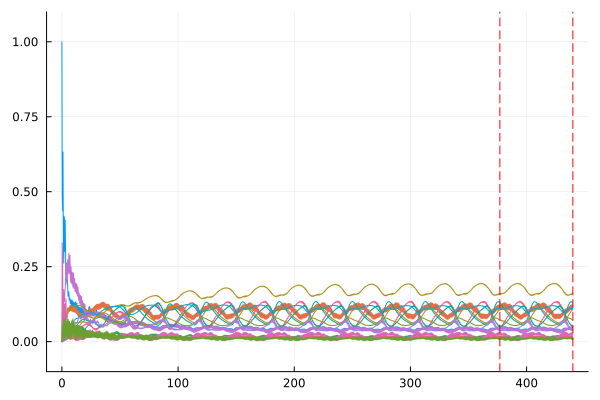

In [157]:
using DifferentialEquations

t_end = 50p.period+1
tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
times = range(0, t_end, 10000)

cb = PeriodicCallback(reset_force!, p.period)
@time sol = DifferentialEquations.solve(prob, DP5(), callback=cb, reltol=1e-3, saveat=times)

# Print the force
println()
print("Force (10³ m/s): ", prob.p.force_last_period * (1e-3 * ħ * k * Γ / m))

using Plots
plot_us = sol.u
plot_ts = sol.t

n_states = size(p.ρ_soa, 1)
plot(
    ylim=(-0.1, 1.1), 
    legend=nothing
)

for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end

plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

### Force versus velocity

Creating a "force profile" (i.e., the force as a function of some variable) can be performed by combining the previous section with the function `force_scan_v3`. The function takes in a `prob` for the OBEs (which we already defined above) and a `scan_values_grid` (essentially a grid of all the values we wish to scan over). Note that `scan_values_grid` may be multidimensional, e.g., we may wish to scan over both position and velocity simultaneously. Indeed, a profile of force versus velocity typically involves averaging over a collection of different starting positions from $\mathbf{r} = (0,0,0)$ to $\mathbf{r} = (2\pi, 2\pi, 2\pi)$ (in units of 1/k), or $\mathbf{r} = (0,0,0)$ to $\mathbf{r} = (\lambda, \lambda, \lambda)$ (in SI units). This ensures that the force is averaged over all possible initial values of the combined laser field seen by the molecule.

Two additional arguments are also required for `force_scan_v3`:
* `prob_func!` _(prob, scan_params, i) -> prob_: Updates the initial `prob` for the `i`th value of the `scan_values_grid`.
* `output_func` _(p, sol) -> force_: Define the output of the solver after `prob` has been solved, typically the force.

In [158]:
using 
    StaticArrays,
    RectiGrids,
    StatsBase

In [159]:
function prob_func!(prob, scan_values_grid, i)
    p = prob.p
    # Update velocity and position
    p.v .= (0, 0, scan_values_grid[i].v)
    p.v .= round_vel(p.v, p.freq_res)
    p.r0 .= scan_values_grid[i].r
    return prob
end
function output_func(p, sol)
    f = p.force_last_period
    return (0, 0, f[3])
end
;

In [160]:
freq_res = 1e-1
p = obe(ρ0, particle, states, lasers, d, true, true; λ=λ, Γ=Γ, freq_res=freq_res)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-3, save_on=false)

di = 2
rs = vcat([(n1/(di+1), n2/(di+1), n3/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = 0:0.1:7.0

scan_values = (r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [161]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


 27.885821 seconds (1.69 M allocations: 324.894 MiB, 0.16% gc time, 62.44% compilation time)


In [185]:
averaged_forces = Float64[]
@time for (i,v) ∈ enumerate(vs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.v == v]
    push!(averaged_forces, mean([f[3] for f in forces[idxs]]))
end

  0.167097 seconds (77.92 k allocations: 5.115 MiB, 98.68% compilation time)


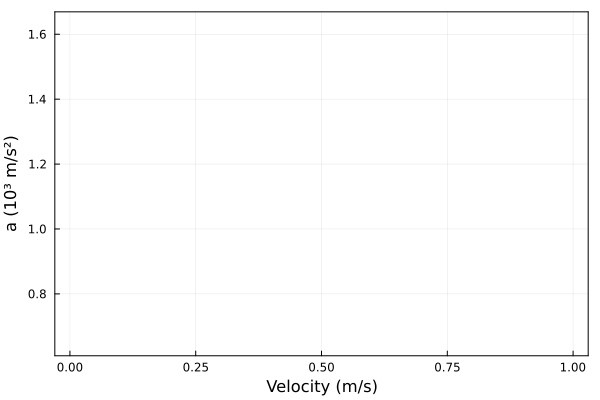

In [186]:
plot(vs, (1e-3 * ħ * k * Γ / m) .* averaged_forces,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    legend=nothing
    )

### Force versus magnetic field

We can also create a force profile versus magnetic field. The `prob_func!` is quite a bit more complicated here since we need to rediagonalize and recompute TDMs for each new value of the magnetic field. We here make use of the `extra_data` argument in `obe` to make sure that the solver has access to the Hamiltonian (as well as a few other variables).

In [164]:
using LinearAlgebra

In [165]:
extra_data = (
    basis_tdms=basis_tdms, 
    X_state_ham=X_state_ham,
    excited_states=excited_states,
    d_ge=d_ge,
    lasers=lasers
);

In [166]:
function prob_func!(prob, scan_params, i)
    p = prob.p

    # Solve Hamiltonian for new `Bz` value (this is expensive, so only do it if the value has changed)
    Bz = scan_params[i].Bz
        
    if p.extra_data.X_state_ham.parameters.B_z != Bz
        
        # Solve X state Hamiltonian for new B_z value
        p.extra_data.X_state_ham.parameters.B_z = Bz
        evaluate!(p.extra_data.X_state_ham)
        QuantumStates.solve!(p.extra_data.X_state_ham)
        
        ground_states = p.extra_data.X_state_ham.states[5:16]
        excited_states = p.extra_data.excited_states
        
        states′ = [ground_states; excited_states]
        
        # Update TDMs
        tdms_between_states!(p.extra_data.d_ge, p.extra_data.basis_tdms, ground_states, excited_states)
        p.d[1:12, 13:16, :] .= p.extra_data.d_ge

        extra_p = (
            basis_tdms=p.extra_data.basis_tdms,
            X_state_ham=p.extra_data.X_state_ham, 
            d_ge=p.extra_data.d_ge,
            excited_states=p.extra_data.excited_states,
            lasers=p.extra_data.lasers
        )
        new_p = obe(
            p.ρ0, p.particle, states′, p.extra_data.lasers, p.d, true, true; λ=p.λ, Γ=p.Γ, freq_res=p.freq_res, extra_data=extra_data
        )
    else
        new_p = p
    end
    
    # Update velocity and position
    new_p.v .= scan_params[i].v 
    new_p.r0 .= scan_params[i].r
    
    # Ensure that frequencies and velocities are rounded
    round_params(new_p)
    new_prob = remake(prob, p=new_p)
    
    return new_prob
end

function output_func(p, sol)
    f = p.force_last_period
    return f
end
;

In [181]:
using RectiGrids

freq_res = 1e-1
p = obe(ρ0, particle, states, lasers, d, true, true; λ=λ, Γ=Γ, freq_res=freq_res, extra_data=extra_data)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-3, save_on=false)

Bs = 0:0.25:5.0
di = 1
rs = vcat([(n1/(di+1), n2/(di+1), n3/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = [0.]

scan_values = (Bz = Bs, r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [182]:
@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:42


162.867655 seconds (175.82 k allocations: 111.401 MiB)


In [183]:
averaged_forces = []
@time for (i,B) ∈ enumerate(Bs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.Bz == B]
    push!(averaged_forces, mean([f[3] for f in forces[idxs]]))
end

  0.116227 seconds (78.08 k allocations: 5.122 MiB, 98.47% compilation time)


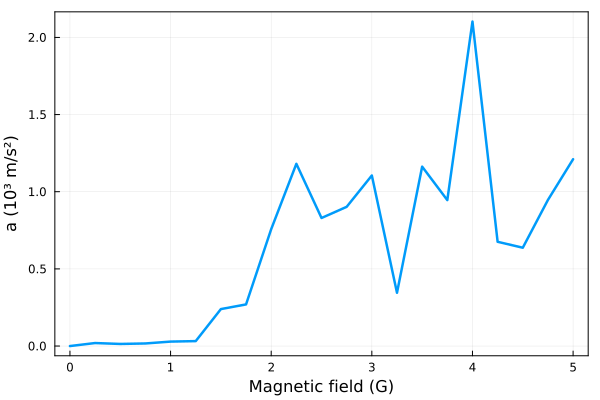

In [184]:
plot(Bs, (1e-3 * ħ * k * Γ / m) .* averaged_forces,
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    legend=nothing
    )

Let's move on to trajectory simulations, here just in 1D. We essentially want a grid for the function $(B,v_z) \rightarrow F_z$, which we can then create an interpolation for that we can use during the trajectory simulations. The grid can be created similarly to our force profiles above using `force_scan_v3`.

In [ ]:
using RectiGrids

In [ ]:
function prob_func!(prob, scan_values, i)
    p = prob.p

    # Solve Hamiltonian for new `Bz` value (this is expensive, so only do it if the value has changed)
    Bz = scan_values[i].B
    vx = scan_values[i].vx
    vy = scan_values[i].vy
    vz = scan_values[i].vz
    r = scan_values[i].r
    
    if p.extra_p.X_state_ham.parameters.B_z != Bz
        
        # Solve X state Hamiltonian for new B_z value
        p.extra_p.X_state_ham.parameters.B_z = Bz
        evaluate!(p.extra_p.X_state_ham)
        QuantumStates.solve!(p.extra_p.X_state_ham)
        for i ∈ eachindex(p.extra_p.X_state_ham.states)
            p.extra_p.X_state_ham.states[i].E *= 1e6
        end
        
        ground_states = p.extra_p.X_state_ham.states[5:16]
        excited_states = p.extra_p.excited_states
        
        states′ = [ground_states; excited_states]
        
        # Update TDMs
        tdms_between_states!(p.extra_p.d_ge, p.extra_p.basis_tdms, ground_states, excited_states)
        p.d[1:12, 13:16, :] .= p.extra_p.d_ge

        extra_p = (
            basis_tdms=p.extra_p.basis_tdms,
            X_state_ham=p.extra_p.X_state_ham, 
            d_ge=p.extra_p.d_ge,
            A_state_caseB_basis=p.extra_p.A_state_caseB_basis, 
            excited_states=p.extra_p.excited_states
        )
        new_p = obe(
            p.ρ0, p.particle, states′, p.extra_p.lasers, p.d, p.d, true, true, p.λ, p.Γ, p.freq_res, extra_p
        )
    else
        new_p = p
    end
    
    # Update velocity and position
    new_p.v .= (vx, vy, vz)
    new_p.r0 .= r
    
    # Ensure that frequencies and velocities are rounded
    round_params(new_p)
    
    return remake(prob, p=new_p)
end
function output_func(p, sol)
    f = p.force_last_period
    return f
end
;

In [ ]:
freq_res = 1e-1
extra_p = (
    basis_tdms=basis_tdms, 
    X_state_ham=X_state_ham,
    d_ge=d_ge,
    A_state_caseB_basis=A_state_caseB_basis,
    excited_states=excited_states,
    lasers=lasers
)
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-3, save_on=false)
;

In [ ]:
# Define the ranges of the grid
grid_range_B = -2:0.2:2
grid_range_vx = 0.:0
grid_range_vy = 0.:0
grid_range_vz = -3:0.2:3

di = 3
grid_range_rs = vcat([(n1/(di+1), n2/(di+1), n3/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)

scan_values = (B = grid_range_B, vx = grid_range_vx, vy = grid_range_vy, vz = grid_range_vz, r = grid_range_rs)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [ ]:
forces, populations = force_scan_v3(prob, scan_values_grid, prob_func!, output_func)
;

Define a dataframe holding all the information about both the forces and excited state populations. We average over all positions scanned in `grid_range_rs`.

In [ ]:
using DataFrames
df = select!(DataFrame(scan_values_grid), keys(scan_values)...)
df.Fz = [x[3] for x ∈ vec(forces) .* (ħ * k * Γ / m)]
df.Ne = [sum(x[13:16]) for x ∈ vec(populations)]

gdf = groupby(df, [:B, :vz])
df = combine(gdf, :Fz => mean, :Ne => mean)
;

We will use a simple linear interpolation for our grid.

In [ ]:
using Interpolations

In [ ]:
nodes = (scan_values_grid.B, scan_values_grid.vz)
itp_force = interpolate(nodes, reshape(df.Fz_mean, [length(node) for node ∈ nodes]...), Gridded(Linear()))
itp_Ne = interpolate(nodes, reshape(df.Ne_mean, [length(node) for node ∈ nodes]...), Gridded(Linear()))
;

In [ ]:
heatmap(scan_values_grid.vz, scan_values_grid.B, itp_force.coefs)
plot!(
    xlabel="Velocity (m/s)",
    ylabel="Magnetic field (G)"
    )